<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">pyGROWAT2D</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);"><b style=color:red;>GRO</b>und<b style=color:red;>WAT</b>er</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
<td><img style="height: 150px;" src="images/pyGROWAT2D.png"></td>
</tr>
</table>

----
# `pyGROWAT2D`

GROundWATer2D, a program package for  flow in porous rocks.

In [2]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
import sys

In this notebook, we solve a **system of linear equations** with two matrix solvers:
- a solver from `numpy` for a **full matrix**
- a solver from `scipy` for a **sparse matrix**

----
## Define system of equations

We define 6 linear equations for the unknown variables $x_i, i \in [1,6]$:
$$
\begin{array}{cccccccl}
-x_1 & +x_2 &      &      &      &      &=& 0 \\
+x_1 & -x_2 & +x_3 &      &      &      &=& 1 \\
     & +x_2 & -x_3 & +x_4 &      &      &=& 1 \\
     &      & +x_3 & -x_4 & +x_5 &      &=& 1 \\
     &      &      & +x_4 & -x_5 & +x_6 &=& 1 \\
     &      &      &      & +x_5 & -x_6 &=& 0 \\
\end{array}
$$
This system of equations can be reformulated as matrix equation:
$$
\underbrace{\left[
\begin{array}{rrrrrr}
-1 & 1 & 0 & 0 & 0 & 0 \\
 1 &-1 & 1 & 0 & 0 & 0 \\
 0 & 1 &-1 & 1 & 0 & 0 \\
 0 & 0 & 1 &-1 & 1 & 0 \\
 0 & 0 & 0 & 1 &-1 & 1 \\
 0 & 0 & 0 & 0 & 1 &-1 \\
\end{array}
\right]}_{\mathbf{A}}
\underbrace{\left[
\begin{array}{c}
x_1 \\ x_2  \\ x_3 \\ x_4 \\ x_5 \\ x_6
\end{array}
\right]}_{\mathbf{x}}
=
\underbrace{\left[
\begin{array}{c}
0 \\ 1  \\ 1 \\ 1 \\ 1 \\ 0
\end{array}
\right]}_{\mathbf{b}}
$$
As solution of this system of equations is
$$\fbox{$
x = [1,1,1,1,1,1]
$}$$
We will test it ...

----
## Set up matrix and right-hand side
We build the system of equations as `numpy` arrays, check them and plot the
matrix with `plt.spy()` as sparsity pattern.

Note that lots of entries are zero (no fill)!

[[-1  1  0  0  0  0]
 [ 1 -1  1  0  0  0]
 [ 0  1 -1  1  0  0]
 [ 0  0  1 -1  1  0]
 [ 0  0  0  1 -1  1]
 [ 0  0  0  0  1 -1]] [0 1 1 1 1 0]


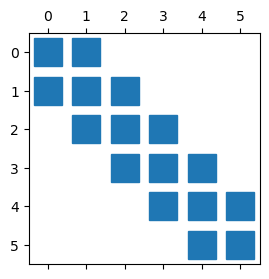

In [3]:
A = np.array([[-1,1,0,0,0,0],
              [1,-1,1,0,0,0],
              [0,1,-1,1,0,0],
              [0,0,1,-1,1,0],
              [0,0,0,1,-1,1],
              [0,0,0,0,1,-1],
              ])

b = np.array([0,1,1,1,1,0])
print(A,b)

plt.figure(figsize=(3,3))
plt.spy(A,markersize=20)

----
## Full-matrix solver
With the **full-matrix solver**, we store the full matrix and solve it.

This can become memory consuming for larger matrices with lots of zero entries ...

In [4]:
Afull = np.copy(A)
print('Full matrix: ',sys.getsizeof(Afull),' bytes')

Full matrix:  416  bytes


We solve the full matrix equations with the `solve` solver of the `numpy.linalg` package.
The result is correct.

In [5]:
x = np.linalg.solve(Afull,b)
print(x)
print(np.allclose(np.dot(Afull,x),b))

[1. 1. 1. 1. 1. 1.]
True


----
## Sparse-matrix solver
More efficient is to store the **sparse-matrix**, only keeping track of the non-zero entries.


In [6]:
# set up sparse lil matrix
Asparse = scipy.sparse.lil_array((6,6))
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        if (A[i,j]!=0):
            Asparse[i,j] = A[i,j]        
print(type(Asparse))
print(Asparse)

# convert sparse lil to csr matrix
Asparse = Asparse.tocsr()
print(type(Asparse))

print('Sparse CSR matrix: ',sys.getsizeof(Asparse),' bytes')

<class 'scipy.sparse._arrays.lil_array'>
  (0, 0)	-1.0
  (0, 1)	1.0
  (1, 0)	1.0
  (1, 1)	-1.0
  (1, 2)	1.0
  (2, 1)	1.0
  (2, 2)	-1.0
  (2, 3)	1.0
  (3, 2)	1.0
  (3, 3)	-1.0
  (3, 4)	1.0
  (4, 3)	1.0
  (4, 4)	-1.0
  (4, 5)	1.0
  (5, 4)	1.0
  (5, 5)	-1.0
<class 'scipy.sparse._arrays.csr_array'>
Sparse CSR matrix:  56  bytes


We solve the sparse matrix equations with the `spsolve` solver of the `scipy.sparse.linalg` package.
The result is correct.

In [7]:
x = scipy.sparse.linalg.spsolve(Asparse,b,permc_spec='MMD_AT_PLUS_A')
print(x)
print(np.allclose(np.dot(Asparse.todense(),x),b))

[1. 1. 1. 1. 1. 1.]
True


----